In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms # 이미지를 다루는 라이브러리

### 내장 데이터셋 로드

- `FashionMNIST` 데이터셋 로드하는 예제


- `root`: 데이터셋을 다운로드 받을 경로(폴더) 지정.
- `train`: `True`로 설정된 경우 `train` 데이터셋에서 로드하며, `False`인 경우 `test` 데이터셋에서 로드
- `download`: `True`로 설정된 경우, 인터넷으로부터 데이터셋을 다운로드 받아 지정된 `root` 디렉토리에 다운로드
- `transform`: 이미지 `transform` 적용


In [ ]:
# Image Transform 정의
# 트랜스폼 - 이미지 augmentation(증강)을 도움. 여러가지 케이스를 만들어줌. 그래서 더 많은 경우의 수를 학습할 수 있게 함.
# 지금은 augmentation 하진 않음.
transform = transforms.Compose(
    [
        transforms.ToTensor(), # 이미지 형태를 텐서 형태로 바꿔주는 것.
    ]
)

In [ ]:
# train(학습용) 데이터셋 로드
train = datasets.FashionMNIST(
    root="data",
    train=True,  # set True
    download=True,  # 다운로드
    transform=transform,  # transform 적용. (0~1 로 정규화)
)

100%|██████████| 26421880/26421880 [00:02<00:00, 9547779.95it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 170155.67it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3216765.26it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22283051.59it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
# test(학습용) 데이터셋 로드
test = datasets.FashionMNIST(
    root="data",
    train=False,  # set to False
    download=True,  # 다운로드
    transform=transform,  # transform 적용. (0~1 로 정규화)
)

`FashionMNIST` 데이터셋 시각화

- 총 10개의 카테고리로 구성되어 있으며, `Label`은 아래 코드에서 `labels_map`에 정의되어 있습니다.
- 출처: [zalandoresearch/fashion-mnist](https://github.com/zalandoresearch/fashion-mnist)


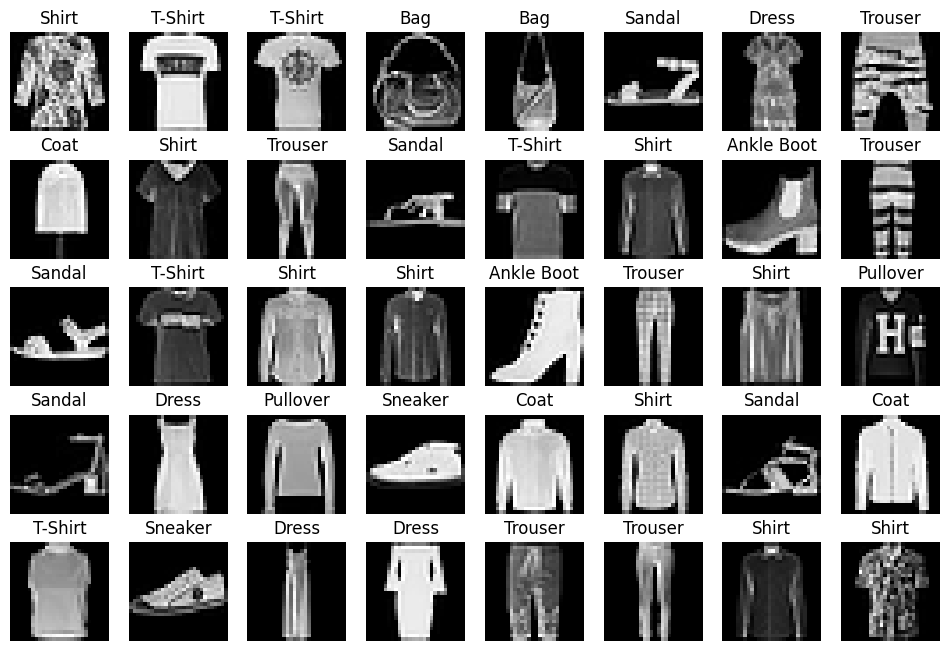

In [ ]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train), size=(1,)).item()
    img, label = train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)), cmap="gray") # 28 28의 흑백사진/(채널 x 세로 x 가로) 흑백이면 채널 1. 컬러면 3
plt.show()

### torch.utils.data.DataLoader로 데이터셋 로더 구성


In [ ]:
batch_size = 32  # batch_size 지정
num_workers = 2  # Thread 숫자 지정 (병렬 처리에 활용할 쓰레드 숫자 지정). 학습할 때 속도 높임, 작업처리를 두명이서 한다.

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, num_workers=num_workers #  num_workers 학습 속도를 올려준다. 이미지를 텐서로 바꿔준다. 2면 2명이서 하는 느낌
)

In [ ]:
test_loader = torch.utils.data.DataLoader(
    test, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

## 모델 생성


In [ ]:
if torch.backends.mps.is_built():
    # mac os mps 지원 체크
    device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
else:
    # cuda 사용 가능한지 체크
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# x는 사진(옷) 2
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)   # Linear는 1차원의 데이터만 들어갈 수 있다. 근데 사진이니까 차원이 달라 오류가 난다. 그래서 평탄화(flatten)한다. 쭉 펴줌
        self.fc2 = nn.Linear(256, 128) # 정답이 없는 값들
        self.fc3 = nn.Linear(128, 32)
        # 마지막 출력층의 Neuron은 Class(from Classification) 개수로 설정
        self.output = nn.Linear(32, num_classes) # num_classes = 10개

    def forward(self, x):
        # (B, 1, 28, 28) -> (B, 28*28) B는 batch size(32,1,28,28)
        x = x.view(-1, 28 * 28)  # 배치는 놔두고 28 * 28. 평탄화한다.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.output(x)
        return x

In [ ]:
# 모델 생성
model = Net(num_classes=10) #가변적으로 정하기 위해 num_classes를 변수로 설정

# 모델을 device 에 올립니다. (cuda:0 혹은 cpu)
model.to(device)
model

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)

## 손실함수 / 옵티마이저 정의


In [ ]:
# CrossEntropyLoss 오차 정의
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저 설정: model.paramters()와 learning_rate 설정
optimizer = optim.Adam(model.parameters(), lr=0.005)

## 훈련


In [ ]:
def train(model, train_loader, optimizer, loss_fn, device):
    model.train()
    final_loss = 0
    running_acc = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        # gradient 초기화
        optimizer.zero_grad()
        # forward pass
        y_hat = model(x)
        # loss 계산
        loss = loss_fn(y_hat, y)
        # backward pass
        loss.backward()
        # weight update
        optimizer.step()
        final_loss += loss.item()
        running_acc += y_hat.argmax(dim=1).eq(y).sum().item() / len(y)   # 정확도
    final_loss /= len(train_loader)
    running_acc /= len(train_loader)
    return final_loss, running_acc


def evaluate(model, test_loader, loss_fn, device):
    # 모델을 평가 모드로 설정
    model.eval()
    final_loss = 0
    running_acc = 0
    with torch.no_grad():

        for x, y in test_loader:
            # 데이터를 device에 올립니다.
            x, y = x.to(device), y.to(device)
            # forward pass
            y_hat = model(x)
            # loss 계산
            loss = loss_fn(y_hat, y)
            # loss 누적
            final_loss += loss.item()
            running_acc += y_hat.argmax(dim=1).eq(y).sum().item() / len(y)
    final_loss /= len(test_loader)
    running_acc /= len(test_loader)
    return final_loss, running_acc

In [ ]:
# 최대 반복 횟수 정의
num_epoch = 20

# loss 기록하기 위한 list 정의
losses = []
val_losses = []

MIN_LOSS = 9999999999.0

# 가중치를 저장할 파일명 정의
STATE_DICT_PATH = "mymodel.pth"

for epoch in range(num_epoch):
    loss, acc = train(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc = evaluate(model, test_loader, loss_fn, device)
    losses.append(loss)
    val_losses.append(val_loss)
    if val_loss < MIN_LOSS:
        print(f"{epoch:05d} [INFO] Model saved... {MIN_LOSS:.5f} ===> {val_loss:.5f}")
        MIN_LOSS = val_loss
        torch.save(model.state_dict(), STATE_DICT_PATH)

    print(
        f"[{epoch:03d}] loss: {loss:.5f} acc: {acc:.5f} val_loss: {val_loss:.5f} val_acc: {val_acc:.5f}"
    )

00000 [INFO] Model saved... 9999999999.00000 ===> 0.44463
[000] loss: 0.53234 acc: 0.80803 val_loss: 0.44463 val_acc: 0.84325
00001 [INFO] Model saved... 0.44463 ===> 0.42386
[001] loss: 0.40741 acc: 0.85312 val_loss: 0.42386 val_acc: 0.85084
[002] loss: 0.37605 acc: 0.86440 val_loss: 0.44161 val_acc: 0.85004
00003 [INFO] Model saved... 0.42386 ===> 0.40462
[003] loss: 0.35754 acc: 0.87000 val_loss: 0.40462 val_acc: 0.85823
[004] loss: 0.34290 acc: 0.87508 val_loss: 0.40739 val_acc: 0.85952
00005 [INFO] Model saved... 0.40462 ===> 0.40171
[005] loss: 0.33059 acc: 0.88053 val_loss: 0.40171 val_acc: 0.85673
00006 [INFO] Model saved... 0.40171 ===> 0.38764
[006] loss: 0.32715 acc: 0.88213 val_loss: 0.38764 val_acc: 0.86442
[007] loss: 0.31803 acc: 0.88565 val_loss: 0.41085 val_acc: 0.86472
00008 [INFO] Model saved... 0.38764 ===> 0.38256
[008] loss: 0.31115 acc: 0.88772 val_loss: 0.38256 val_acc: 0.86891
[009] loss: 0.30650 acc: 0.89080 val_loss: 0.40205 val_acc: 0.86651


KeyboardInterrupt: 

## 저장한 가중치 로드


In [ ]:
model.load_state_dict(torch.load(STATE_DICT_PATH))

<All keys matched successfully>

## 최종 성능 평가


In [ ]:
# 검증모드 진입
model.eval()
# loss 초기화
running_loss = 0
# 정확도 계산
running_acc = 0

with torch.no_grad():
    for (
        x,
        y,
    ) in test_loader:
        x, y = x.to(device), y.to(device)

        output = model(x)

        running_loss += loss
        running_acc += output.argmax(dim=1).eq(y).sum().item() / len(y)

    loss = running_loss / len(test_loader)
    acc = running_acc / len(test_loader)

# 최종 훈련 결과확인
print(f"Loss: {loss:.5f}, Accuracy: {acc:.5f}")

Loss: 0.30397, Accuracy: 0.86891
